# Cluster and Waveform Quality Metrics Analysis for the DataJoint Workflow: Exploration of Results


This notebook aims to explore the results obtained for the quality metrics through the array electrophysiology pipeline. New cells can be added to explore each table's dependencies and attributes.

**_Note:_**

- The examples in this notebook use a sample dataset. Replace these entries with your actual database entries to access and analyze your data.



### **Key Steps**

- **Setup**

- **Step 1: Select Session of Interest**

- **Step 2: Cluster Quality Metrics Exploration**

  - **2.1. Plot Cluster QM Histograms**

  - **2.2. Filtering Cluster QMs**

- **Step 3: Waveform Quality Metrics Exploration**

  - **3.1. Plot Waveform QM Histograms**

  - **3.2. Filtering Waveform QMs**


#### **Setup**


First, import the necessary packages for the data pipeline and essential schemas.


In [51]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [52]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from workflow.pipeline import culture, ephys

#### **Step 1: Select Session of Interest**


In [54]:
(culture.Experiment & 'organoid_id="O09"').proj(
    "experiment_end_time",
    "drug_name",
    "experiment_plan",
)

[2024-07-18 11:59:37,548][WARNING]: MySQL server has gone away. Reconnecting to the server.


organoid_id e.g. O17,experiment_start_time,experiment_end_time,drug_name,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing"
O09,2023-05-03 17:33:00,2023-05-18 12:15:00,Control,ephys
O09,2023-05-18 12:25:00,2023-05-18 18:15:00,4-AP,ephys
O09,2023-05-18 18:15:00,2023-05-19 09:30:00,No Drug,ephys
O09,2023-05-19 09:30:00,2023-05-19 15:35:00,Bicuculline,ephys
O09,2023-05-19 15:45:00,2023-05-20 15:40:00,Tetrodotoxin,ephys


Let's select the `4-AP` drug and `bicuculline` as key examples for organoid `O09`:

In [55]:
ap_key = dict(
    organoid_id="O09",
    experiment_start_time="2023-05-18 12:25:00",
    insertion_number=0,
    start_time="2023-05-18 12:25:00",
    end_time="2023-05-18 12:30:00",
)

bic_key = dict(
    organoid_id="O09",
    experiment_start_time="2023-05-19 09:30:00",
    insertion_number=0,
    start_time="2023-05-19 10:00:00",
    end_time="2023-05-19 10:05:00",
)

In [56]:
ephys.EphysSession * ephys.EphysSessionInfo & ap_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type,session_info Session header info from intan .rhd file. Get this from the first session file.
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,spike_sorting,=BLOB=


In [57]:
ephys.EphysSession * ephys.EphysSessionInfo & bic_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type,session_info Session header info from intan .rhd file. Get this from the first session file.
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,spike_sorting,=BLOB=


In [58]:
ephys_ap_key = dict(**ap_key, paramset_idx=1)
ephys_bic_key = dict(**bic_key, paramset_idx=1)

#### **Step 2: Cluster Quality Metrics Exploration**

In [59]:
ephys.QualityMetrics & ephys_ap_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1


In [60]:
ephys.QualityMetrics & ephys_bic_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1


##### **2.1. Plot Cluster QM Histograms**


In [63]:
query1 = ephys.QualityMetrics.Cluster & ephys_ap_key
query2 = ephys.QualityMetrics.Cluster & ephys_bic_key

In [64]:
query1.heading

# Cluster metrics for a particular unit
organoid_id          : varchar(4)                   # e.g. O17
experiment_start_time : datetime                     # 
insertion_number     : tinyint unsigned             # 
start_time           : datetime                     # 
end_time             : datetime                     # 
paramset_idx         : smallint                     # 
unit                 : int                          # 
---
firing_rate=null     : float                        # (Hz) firing rate for a unit
snr=null             : float                        # signal-to-noise ratio for a unit
presence_ratio=null  : float                        # fraction of time in which spikes are present
isi_violation=null   : float                        # rate of ISI violation as a fraction of overall rate
number_violation=null : int                          # total number of ISI violations
amplitude_cutoff=null : float                        # estimate of miss rate based on amplitude histog

In [135]:
def plot_metric(
    ax,
    data,
    bins,
    x_axis_label=None,
    title=None,
    color="k",
    smoothing=True,
    density=False,
):
    """A function modified from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html"""
    from scipy.ndimage import gaussian_filter1d

    if any(data) and np.nansum(data):
        h, b = np.histogram(data, bins=bins, density=density)
        x = b[:-1]

        y = gaussian_filter1d(h, 1) if smoothing else h
        width = np.diff(b)
        ax.bar(x, y, width=width, color=color, edgecolor="black", align="edge")
        ax.set_xlabel(x_axis_label)
        ax.set_ylim([0, None])
    ax.set_title(title)
    ax.spines[["right", "top"]].set_visible(False)

In [136]:
def plot_histograms(key, query):
    fig, axes = plt.subplots(4, 4, figsize=(25, 10))
    axes = axes.flatten()
    plt.suptitle(f"Cluster Quality Metrics for {key}", y=0.99, fontsize=14)

    # Firing Rates
    data = np.log10(query.fetch("firing_rate"))
    bins = np.linspace(-3, 6, 100)  # from 0.001 Hz to 100 Hz.
    plot_metric(axes[0], data, bins, title="Firing Rate (Hz) (log$_{10}$)")
    axes[0].set_ylabel("Count")

    # Signal-to-Noise Ratio
    data = query.fetch("snr")
    bins = np.linspace(0, 10, 100)  # signal quality: the better the higher
    plot_metric(axes[1], data, bins, title="Signal-to-Noise Ratio")

    # Presence Ratio
    data = query.fetch("presence_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # a high presence (1) may indicate strong and consistent signal, neuron active
    plot_metric(
        axes[2],
        data,
        bins,
        title="Presence Ratio",
    )

    # ISI Violation
    data = query.fetch("isi_violation")
    bins = np.linspace(
        0, 1, 100
    )  # proportion of spikes that occur within a certain short interval (violating the refractory period of a neuron). High value may suggest presence of noise. For neural recordings, a lower ISI Violation ratio is usually preferred because it indicates higher quality data where detected spikes are less likely to be false positives.
    plot_metric(
        axes[3],
        data,
        bins,
        title="ISI Violation",
    )

    # Number Violation
    data = query.fetch("number_violation")
    bins = np.linspace(
        0, 10000, 100
    )  # close to 1000 poor spike sorting or high noise levels.
    plot_metric(
        axes[4],
        data,
        bins,
        title="Number Violation",
    )
    axes[4].set_ylabel("Count")

    # Amplitude Cutoff
    data = query.fetch("amplitude_cutoff")
    bins = np.linspace(
        0, 0.5, 100
    )  # higher value suggests potential issues with spike detection, such as noise or missed spikes.
    plot_metric(
        axes[5],
        data,
        bins,
        title="Amplitude Cutoff",
    )

    # Isolation Distance
    data = query.fetch("isolation_distance")
    bins = np.linspace(
        0, 170, 50
    )  # higher value suggests detected spikes are well-separated from noise and other neurons, implying high-quality spike sorting.
    plot_metric(
        axes[6],
        data,
        bins,
        title="Isolation Distance",
    )

    # L-Ratio
    data = query.fetch("l_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # lower value indicates better separation between clusters of spikes.
    plot_metric(axes[7], data, bins, title="L-Ratio")

    # d-Prime
    data = query.fetch("d_prime")
    bins = np.linspace(
        0, 15, 50
    )  # measure used in signal detection theory to quantify the ability of an observer to distinguish between signal and noise. Higher values indicate better separation between clusters of spikes.
    plot_metric(axes[8], data, bins, title="d-Prime")
    axes[8].set_ylabel("Count")

    # Nearest-Neighbors Hit Rate
    data = query.fetch("nn_hit_rate")
    bins = np.linspace(
        0, 1, 100
    )  # A higher Nearest-Neighbors Hit Rate indicates better clustering or classification performance
    plot_metric(
        axes[9],
        data,
        bins,
        title="Nearest-Neighbors Hit Rate",
    )

    # Nearest-Neighbors Miss Rate
    data = query.fetch("nn_miss_rate")
    bins = np.linspace(
        0, 1, 100
    )  # a lower Nearest-Neighbors Miss Rate indicates better clustering or classification performance, as it suggests that the nearest neighbors tend to belong to the same class or cluster.
    plot_metric(
        axes[10],
        data,
        bins,
        title="Nearest-Neighbors Miss Rate",
    )

    # Silhouette Score
    data = query.fetch("silhouette_score")
    bins = np.linspace(
        -1, 1, 100
    )  # It measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
    plot_metric(axes[11], data, bins, title="Silhouette Score")

    # Max Drift
    data = query.fetch("max_drift")
    bins = np.linspace(
        0, 100, 100
    )  # It measures the amount of movement or displacement of the recording electrode during the experiment. A high value may indicate that the electrode was not stable during the recording session.
    plot_metric(
        axes[12],
        data,
        bins,
        title="Max Drift",
    )
    axes[12].set_ylabel("Count")

    # Cumulative Drift
    data = query.fetch("cumulative_drift")
    bins = np.linspace(
        0, 100, 100
    )  # total movement or displacement of the recording electrode throughout the experiment duration
    plot_metric(
        axes[13],
        data,
        bins,
        title="Cumulative drift",
    )

    # Contamination Rate
    data = query.fetch("contamination_rate")
    bins = np.linspace(
        0, 1, 100
    )  # percentage of data points in a cluster that are not members of that cluster. A high contamination rate may indicate that the cluster contains a significant number of spikes from other neurons.
    plot_metric(axes[14], data, bins, title="Contamination Rate")

    [ax.remove() for ax in axes[15:]]
    plt.tight_layout()

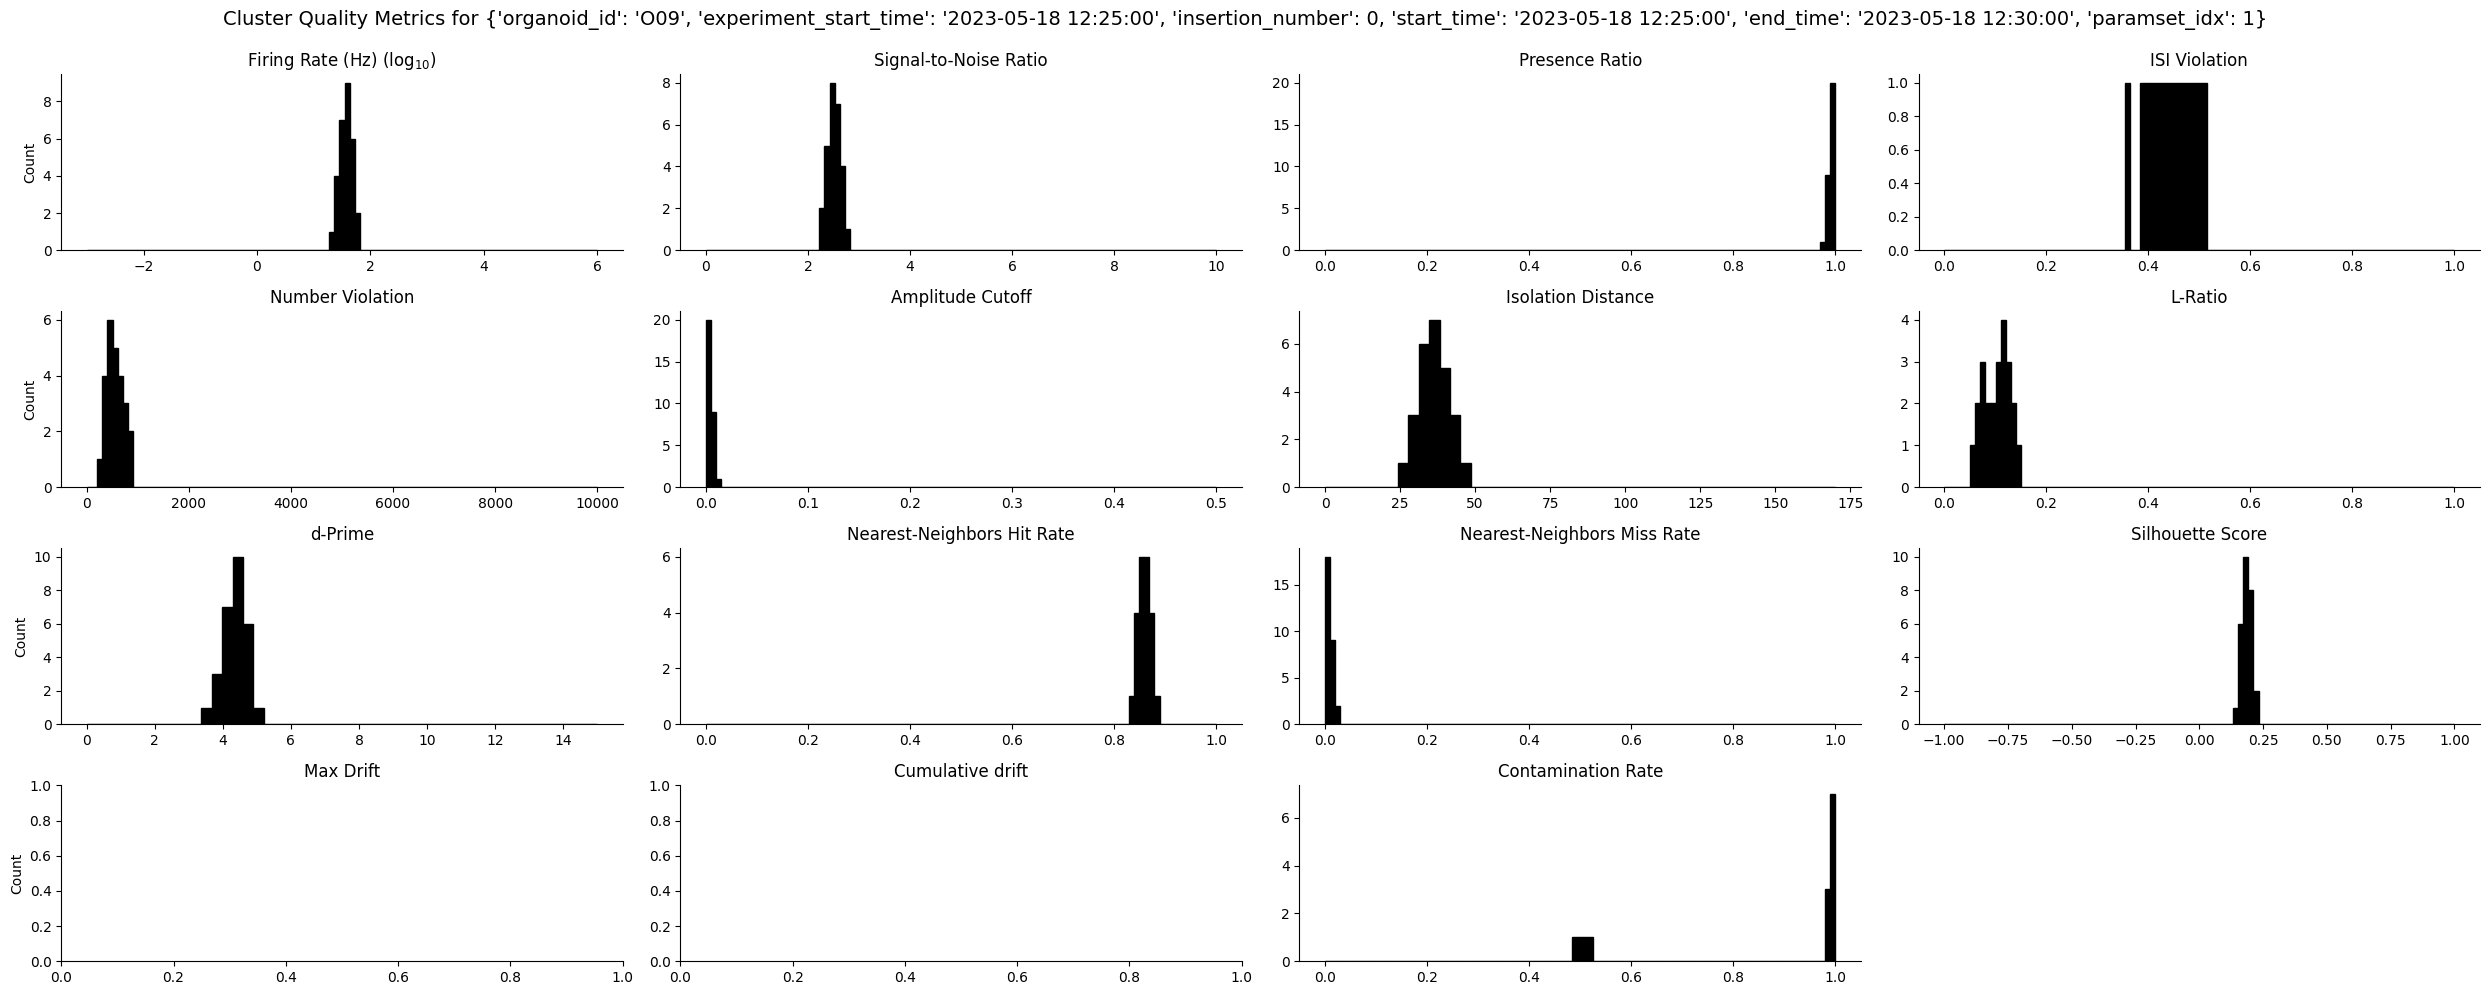

In [137]:
plot_histograms(ephys_ap_key, query1)

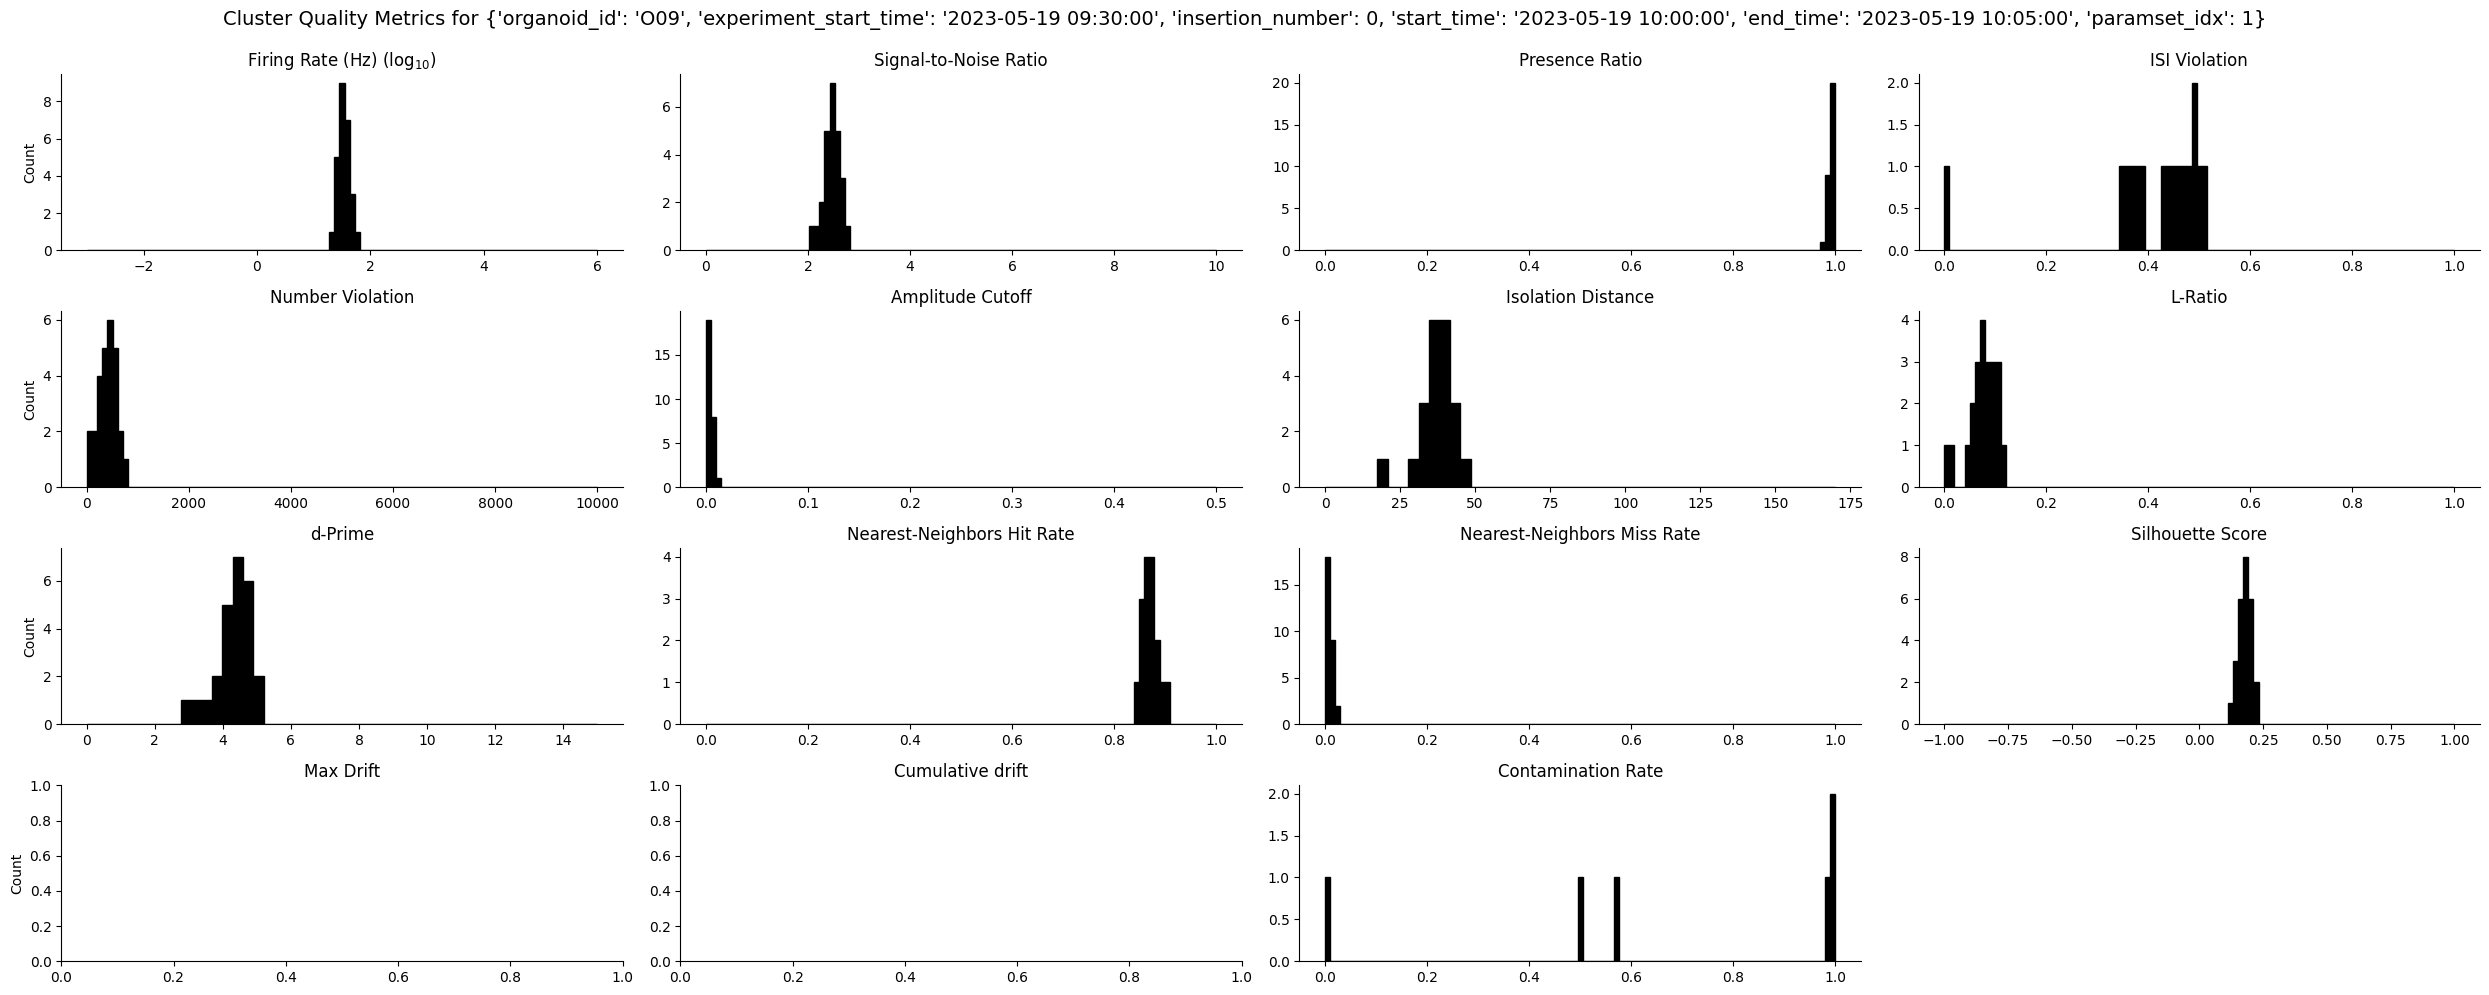

In [138]:
plot_histograms(ephys_bic_key, query2)

##### **2.2. Filtering Cluster QMs**


In [73]:
len(query1), len(query2)

(32, 33)

In [97]:
len(
    query1 & "presence_ratio > 0.9" & "isi_violation > 0.4" & "contamination_rate > 0.5"
)

22

In [98]:
len(
    query2 & "presence_ratio > 0.9" & "isi_violation > 0.4" & "contamination_rate > 0.5"
)

20

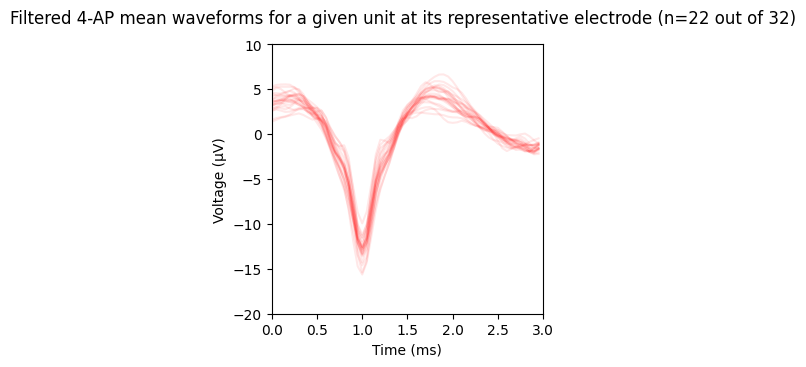

In [95]:
filtered_key = (
    query1 & "presence_ratio > 0.9" & "isi_violation > 0.4" & "contamination_rate > 0.5"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Filtered 4-AP mean waveforms for a given unit at its representative electrode (n={len(filtered_key)} out of {len(query1)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

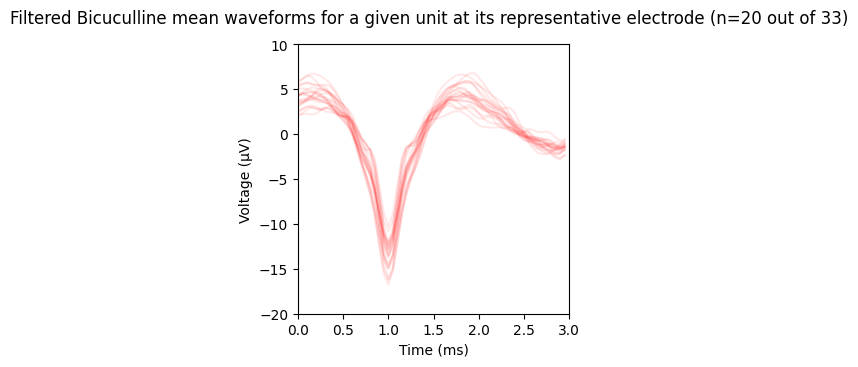

In [96]:
filtered_key = (
    query2 & "presence_ratio > 0.9" & "isi_violation > 0.4" & "contamination_rate > 0.5"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Filtered Bicuculline mean waveforms for a given unit at its representative electrode (n={len(filtered_key)} out of {len(query2)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### **Step 3: Waveform Quality Metrics Exploration**


In [99]:
ephys.QualityMetrics.Waveform & ephys_ap_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,0,-9.555,0.00062,0.00023,-0.241835,35015.7,-2301.64,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,1,-12.285,0.000745,0.00027,-0.326784,33418.9,-5696.13,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,2,-12.675,0.000735,0.00026,-0.3289,36164.7,-5744.16,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,3,-12.3825,0.00075,0.00026,-0.339903,33851.9,-5715.39,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,4,-15.015,0.000805,0.000265,-0.351592,44949.6,-9028.7,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,5,-13.26,0.00072,0.000295,-0.396584,36574.8,-7082.93,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,6,-13.065,0.000705,0.0003,-0.422852,38696.7,-7232.85,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,7,-12.48,0.000785,0.000335,-0.415374,32865.4,-8344.88,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,8,-14.43,0.000915,0.000325,-0.413178,38703.7,-10111.6,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,1,9,-11.505,0.000825,0.000305,-0.371703,32242.8,-6144.37,0.0,nan,nan


In [100]:
ephys.QualityMetrics.Waveform & ephys_bic_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,0,-15.405,0.00093,0.000365,-0.397685,45522.3,-12266.8,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,1,-14.04,0.000785,0.000385,-0.417879,37746.5,-7425.91,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,2,-11.7,0.00078,0.00033,-0.392252,31855.2,-5267.43,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,3,-13.26,0.00069,0.00024,-0.288938,49292.1,-5809.93,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,4,-13.455,0.000855,0.000335,-0.426315,32761.8,-10908.6,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,5,-12.87,0.00089,0.000275,-0.354699,36311.2,-7341.52,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,6,-15.795,0.00084,0.0003,-0.3368,45860.1,-8620.62,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,7,-14.625,0.00094,0.000415,-0.494443,37563.1,-13989.7,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,8,-12.675,0.00082,0.000275,-0.334904,36228.1,-7521.79,0.0,nan,nan
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,9,-14.235,0.000875,0.00035,-0.410854,39122.7,-8471.52,0.0,nan,nan


##### **3.1. Plot Waveform QM Histograms**


In [101]:
query3 = ephys.QualityMetrics.Waveform & ephys_ap_key
query4 = ephys.QualityMetrics.Waveform & ephys_bic_key

In [102]:
query3.heading

# Waveform metrics for a particular unit
organoid_id          : varchar(4)                   # e.g. O17
experiment_start_time : datetime                     # 
insertion_number     : tinyint unsigned             # 
start_time           : datetime                     # 
end_time             : datetime                     # 
paramset_idx         : smallint                     # 
unit                 : int                          # 
---
amplitude=null       : float                        # (uV) absolute difference between waveform peak and trough
duration=null        : float                        # (ms) time between waveform peak and trough
halfwidth=null       : float                        # (ms) spike width at half max amplitude
pt_ratio=null        : float                        # absolute amplitude of peak divided by absolute amplitude of trough relative to 0
repolarization_slope=null : float                        # the repolarization slope was defined by fitting a regression line

In [139]:
def plot_wf_histograms(key, wf_query):
    fig, axes = plt.subplots(3, 2, figsize=(25, 10))
    axes = axes.flatten()
    plt.suptitle(f"Waveform Quality Metrics for {key}", y=0.99, fontsize=14)

    # Amplitude
    data = wf_query.fetch("amplitude")
    bins = np.linspace(-30, 0, 50)
    plot_metric(axes[0], data, bins, title="Amplitude")
    axes[0].set_ylabel("Count")
    axes[0].set_xlabel("Amplitude (μV)")

    # Duration
    data = wf_query.fetch("duration") * 1e3  # s -> ms
    bins = np.linspace(0, 0.001, 50) * 1e3  # in s -> ms
    plot_metric(
        axes[1], data, bins, title="Duration: Time between waveform peak and trough "
    )
    axes[1].set_xlabel("Duration (ms)")

    # Spike Width at half max amplitude
    data = wf_query.fetch("halfwidth") * 1e3  # s -> ms
    bins = np.linspace(0, 0.001, 50) * 1e3  # in s -> ms
    plot_metric(
        axes[2],
        data,
        bins,
        title="Spike Width at half max amplitude",
    )
    axes[2].set_ylabel("Count")
    axes[2].set_xlabel("Duration (ms)")

    # PT Ratio
    data = wf_query.fetch("pt_ratio")
    bins = np.linspace(-1, 1, 50)
    plot_metric(
        axes[3],
        data,
        bins,
        title="Peak-Trough Ratio",  # A PT Ratio closer to 1 indicates that the peak and trough have similar amplitudes, suggesting a symmetric waveform. A PT Ratio significantly different from 1 indicates asymmetry in the waveform, with the peak or trough being more prominent.
    )

    # Repolarization Slope
    data = wf_query.fetch("repolarization_slope")
    bins = np.linspace(10e3, 100e3, 50)
    plot_metric(
        axes[4],
        data,
        bins,
        title="Repolarization Slope",
    )
    axes[4].set_ylabel("Count")

    # Spread
    data = wf_query.fetch("spread")
    bins = np.linspace(0, 250, 50)
    plot_metric(
        axes[5],
        data,
        bins,
        title="Spread",
    )
    axes[5].set_xlabel("Spread (μm)")

    plt.tight_layout()
    plt.show()

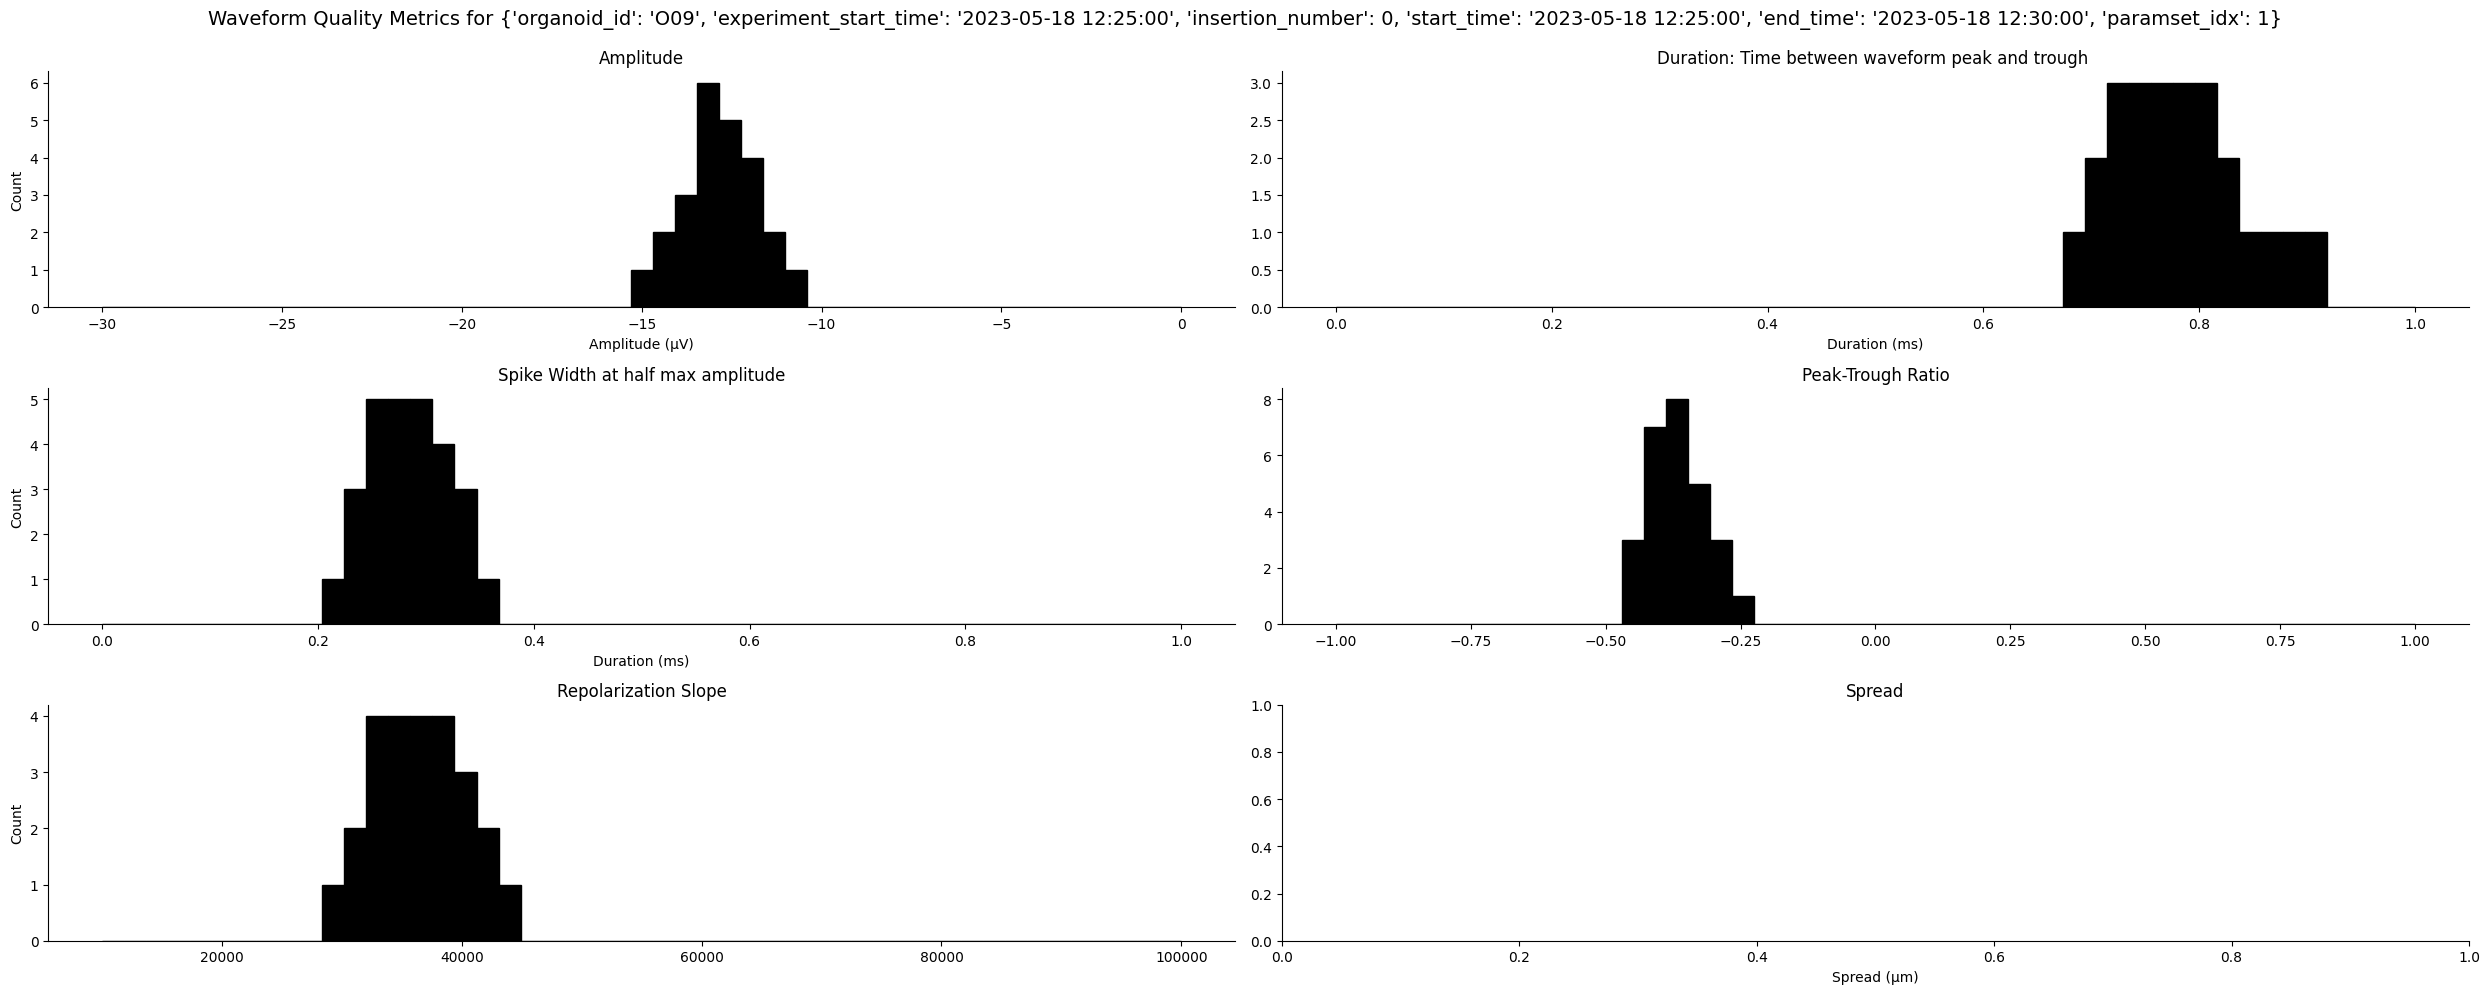

In [140]:
plot_wf_histograms(ephys_ap_key, query3)

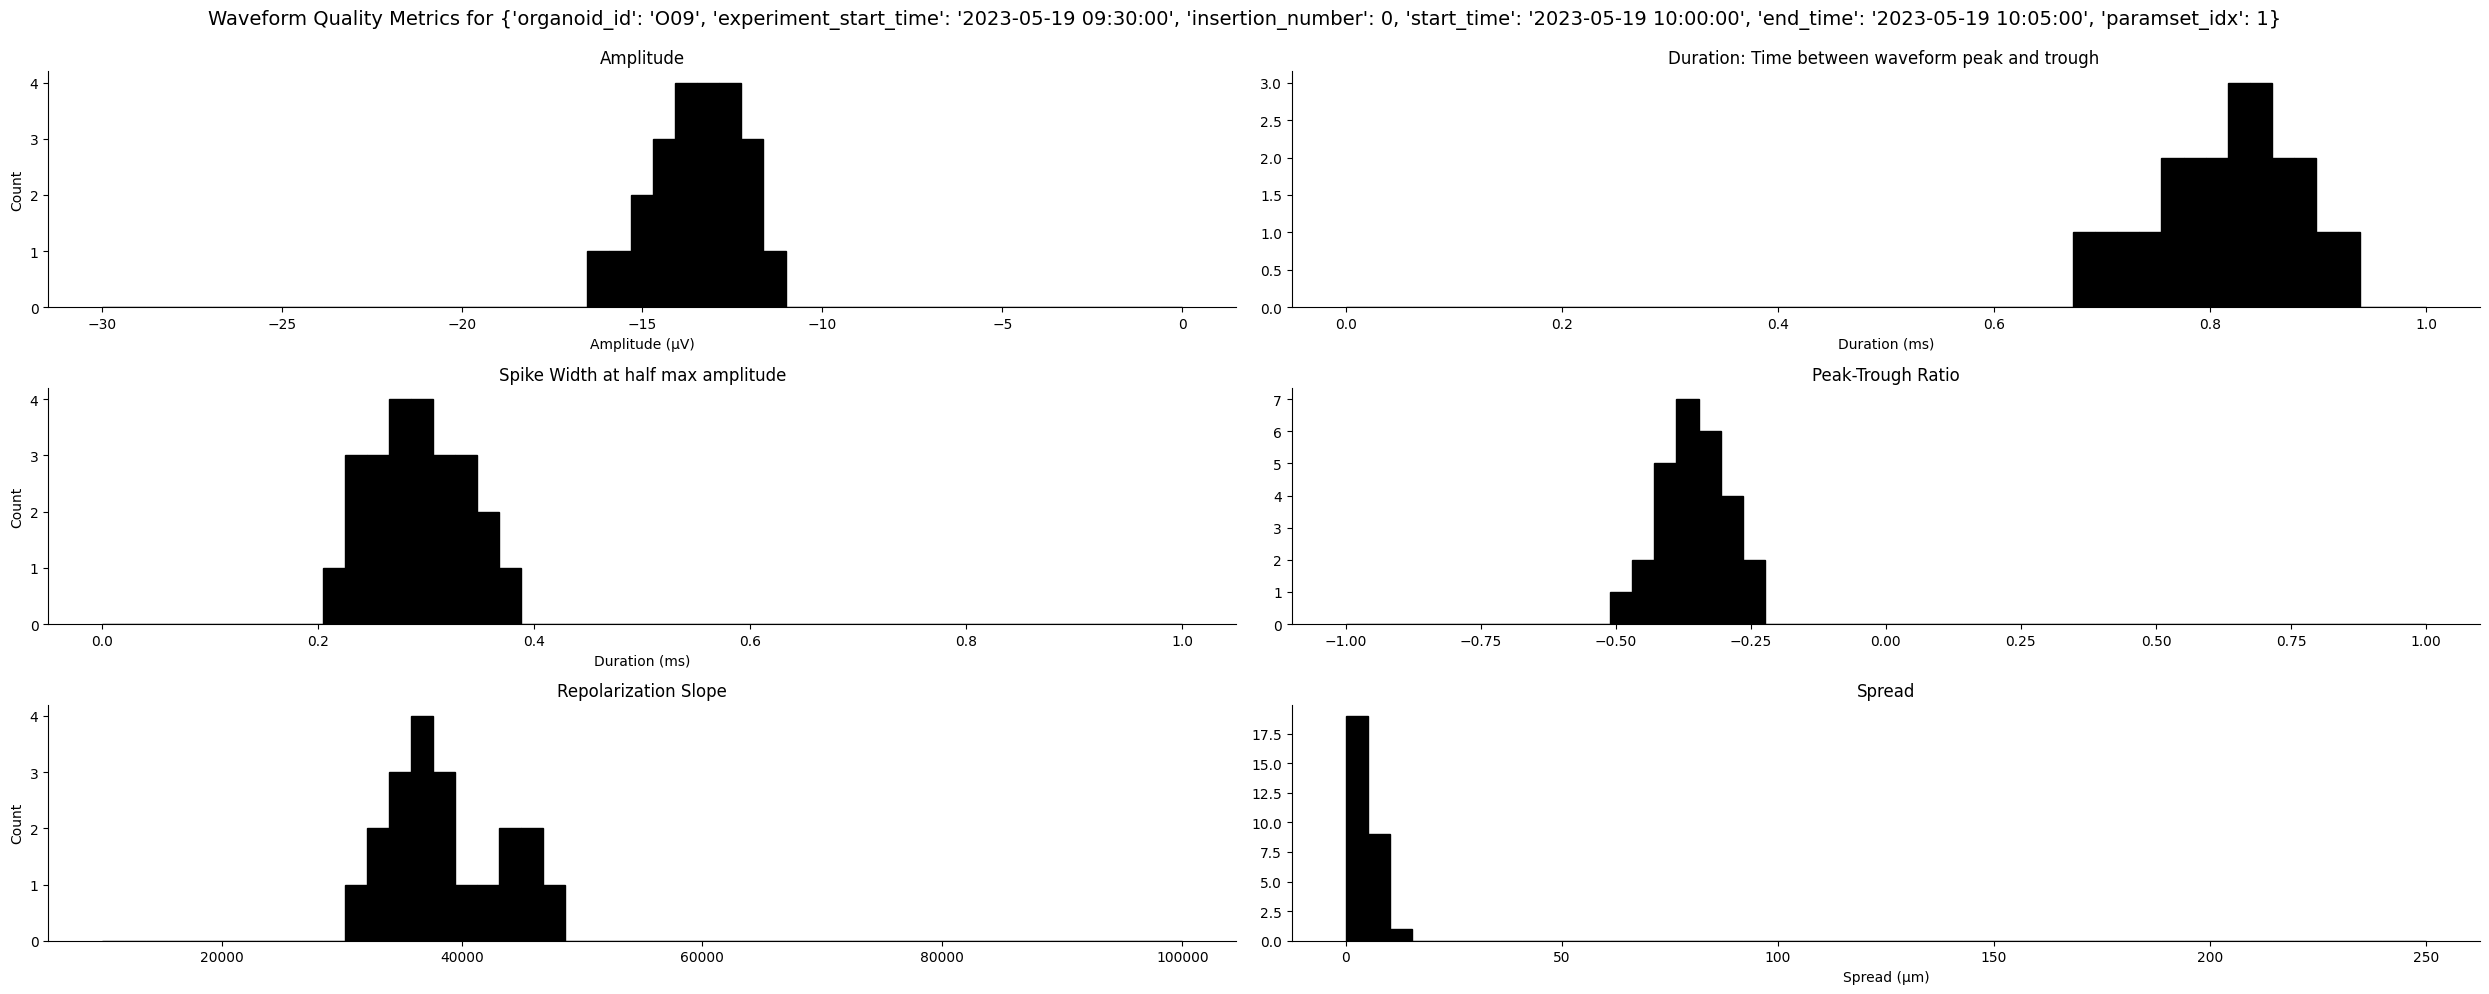

In [141]:
plot_wf_histograms(ephys_bic_key, query4)

##### **2.2. Filtering Waveform QMs**


In [106]:
len(query3), len(query4)

(32, 33)

In [130]:
len(
    query3
    # & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    & "duration > 0.0007"
    & "pt_ratio < -0.3"
)

25

In [131]:
len(
    query4
    # & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    & "duration > 0.0007"
    & "pt_ratio < -0.3"
)

27

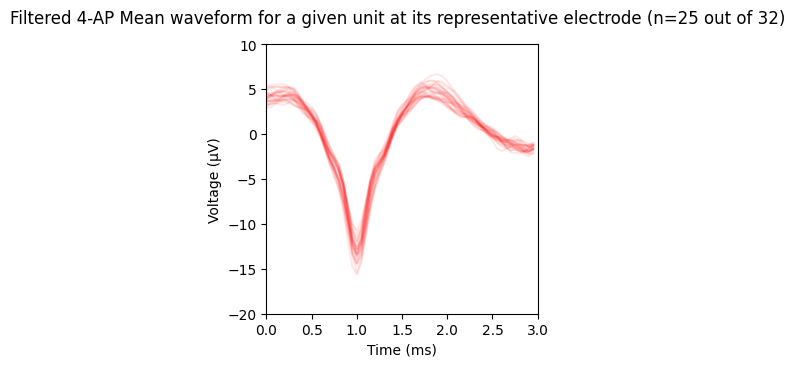

In [133]:
filtered_key = (query3 & "pt_ratio < -0.3" & "duration > 0.0007").fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Filtered 4-AP Mean waveform for a given unit at its representative electrode (n={len(filtered_key)} out of {len(query3)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

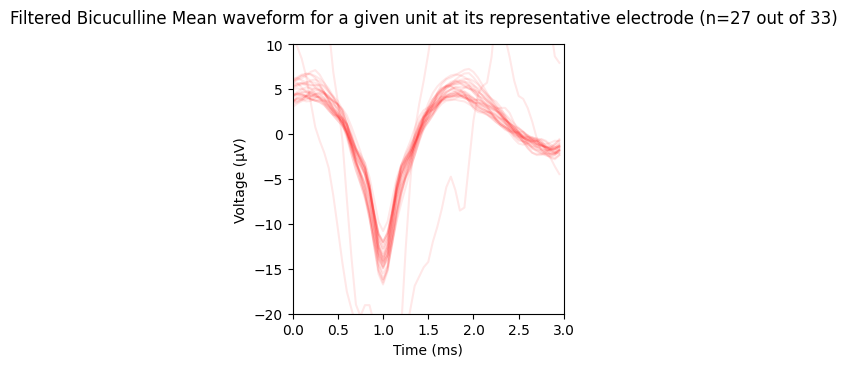

In [134]:
filtered_key = (query4 & "pt_ratio < -0.3" & "duration > 0.0007").fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Filtered Bicuculline Mean waveform for a given unit at its representative electrode (n={len(filtered_key)} out of {len(query4)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()